In [ ]:
# Import the required libraries
import os
import pandas as pd
import torch
import numpy as np

In [ ]:
from PIL import Image
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader


In [ ]:
from torch.optim import SGD, lr_scheduler
from torch.nn import CrossEntropyLoss
from sklearn.metrics import accuracy_score

In [ ]:
# Define the class enhanced image dataset
class EnhancedImageDataset(Dataset):
    def __init__(self, annotation_path, images_folder, transformation=None):
        self.image_annotations = pd.read_csv(annotation_path)
        self.images_folder = images_folder
        self.transformation = transformation

    def __len__(self):
        return len(self.image_annotations)

    def __getitem__(self, index):
        image_file = os.path.join(self.images_folder, self.image_annotations.iloc[index, 0])
        image = Image.open(image_file).convert('RGB')
        label = self.image_annotations.iloc[index, 5]
        label = torch.tensor(label).long()
        if self.transformation:
            image = self.transformation(image)

        return image, label

In [ ]:
def calculate_iou(box1, box2):
    # Ensure that the boxes are (x_min, y_min, x_max, y_max)
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # Calculate the intersection values
    x_min_inter = max(x1_min, x2_min)
    y_min_inter = max(y1_min, y2_min)
    x_max_inter = min(x1_max, x2_max)
    y_max_inter = min(y1_max, y2_max)
   # Calculate the inter area
    inter_area = max(x_max_inter - x_min_inter, 0) * max(y_max_inter - y_min_inter, 0)

    # Calculate union values
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = box1_area + box2_area - inter_area

    # Calculate IoU
    iou = inter_area / union_area if union_area != 0 else 0
    # Return the IoU
    return iou

In [ ]:
# transformations on the images
advanced_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
])




In [ ]:
# Create the train datasets and the test datasets
train_data = EnhancedImageDataset(
    annotation_path='C:/Users/Shilpa/Downloads/Cow_stall_number-main/train.csv',
    images_folder='C:/Users/Shilpa/Downloads/Cow_stall_number-main/Stall_num_images',
    transformation=advanced_transform
)

In [ ]:
test_data = EnhancedImageDataset(
    annotation_path='C:/Users/Shilpa/Downloads/Cow_stall_number-main/test.csv',
    images_folder='C:/Users/Shilpa/Downloads/Cow_stall_number-main/Stall_num_images',
    transformation=advanced_transform
)

In [ ]:
batch_size = 16
# train and test loaders defined here
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
# the resnet model defined
advanced_model = models.resnet50(pretrained=True)
for param in advanced_model.parameters():
    param.requires_grad = False

for param in advanced_model.layer4.parameters():
    param.requires_grad = True

# model's final layer
num_features = advanced_model.fc.in_features
advanced_model.fc = torch.nn.Linear(num_features, len(pd.unique(train_data.image_annotations["class_names"])))

In [ ]:
# Define loss and optimizer
class_weights = torch.tensor([1.0, 2.0, 3.0], dtype=torch.float)
criterion = CrossEntropyLoss(weight=class_weights.to(device))

In [ ]:
# Adam optimizer
optimizer = Adam(filter(lambda p: p.requires_grad, advanced_model.parameters()), lr=0.0001)

In [ ]:
# ReduceLROnPlateau scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
advanced_model.to(device)
epochs = 75
epoch_loss_history = []

In [ ]:

# Training loop ran through
for epoch in range(epochs):
    running_loss = 0.0
    advanced_model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = advanced_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    scheduler.step(running_loss / len(train_loader))
    epoch_loss = running_loss / len(train_loader)
    epoch_loss_history.append(epoch_loss)

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader)}')

Epoch 1/75, Loss: 3.8383371757738516
Epoch 2/75, Loss: 3.4978700659491797
Epoch 3/75, Loss: 3.3429870171980425
Epoch 4/75, Loss: 3.1376505692799888
Epoch 5/75, Loss: 2.9278455990733523
Epoch 6/75, Loss: 2.7189522530093337
Epoch 7/75, Loss: 2.4410471139532146
Epoch 8/75, Loss: 2.145700053735213
Epoch 9/75, Loss: 2.0864539236733406
Epoch 10/75, Loss: 2.0573006452936116
Epoch 11/75, Loss: 1.9963155406894106
Epoch 12/75, Loss: 1.9688972559842197
Epoch 13/75, Loss: 1.9283840981396763
Epoch 14/75, Loss: 1.9080494551947622
Epoch 15/75, Loss: 1.861585006569371
Epoch 16/75, Loss: 1.8746157595605561
Epoch 17/75, Loss: 1.8536562991864753
Epoch 18/75, Loss: 1.8484006036411633
Epoch 19/75, Loss: 1.8719113902612166
Epoch 20/75, Loss: 1.8465588905594565
Epoch 21/75, Loss: 1.8395763238271077
Epoch 22/75, Loss: 1.8414322354576804
Epoch 23/75, Loss: 1.8262628750367598
Epoch 24/75, Loss: 1.8544111974311597
Epoch 25/75, Loss: 1.8463305108474963
Epoch 26/75, Loss: 1.853250705834591
Epoch 27/75, Loss: 1.847

In [ ]:
print('\n\nTraining Complete\n\n')



Training Complete




In [ ]:
# Model evaluation
advanced_model.eval()
predicted_labels = []
true_labels = []

In [ ]:

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = advanced_model(inputs)
        _, predictions = torch.max(outputs, 1)
        predicted_labels.extend(predictions.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predicted_labels)


In [ ]:
print(f'Accuracy on Test Data: {accuracy * 100:.2f}%')

Accuracy on Test Data: 73.65%


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), epoch_loss_history, marker='o')

In [ ]:
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

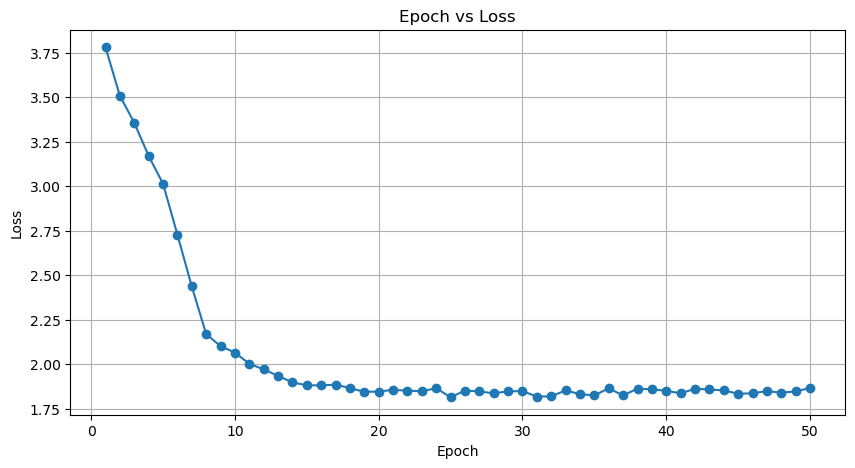

In [ ]:
plt.grid(True)
plt.show()

The Paper Link is mentioned below.

https://www.researchgate.net/publication/375833306_CowStallNumbers_A_Small_Dataset_for_Stall_Number_Detection_of_Cow_Teats_Images_using_Object_Detection_Model